# **Supermarket Customer Churn Prediction**


**Imports**

In [ ]:
from itertools import chain
import pandas as pd
import sklearn
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import figure

#Data Preparation
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report, roc_auc_score

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
import lightgbm
import xgboost

#from tpot import TPOTClassifier

from tensorflow import keras 


**Loading dataset**

The original dataset was pivoted to make a dataset with a single time series for each customer

In [ ]:
ds2 = pd.read_csv("/content/drive/My Drive/Datastorm/ds2.csv") #Dataset with monthly purchased time series 

In [ ]:
ds2 = ds2.drop(["Unnamed: 0"],axis=1) #Dropping unwanted column
ds2.head()

,customer_id,2017/01/31,2017/02/28,2017/03/31,2017/04/30,2017/05/31,2017/06/30,2017/07/31,2017/08/31,2017/09/30,2017/10/31,2017/11/30,2017/12/31,2018/01/31,2018/02/28,2018/03/31,2018/04/30,2018/05/31,2018/06/30,2018/07/31,2018/08/31,2018/09/30,2018/10/31,2018/11/30,2018/12/31,2019/01/31,2019/02/28,2019/03/31,2019/04/30,2019/05/31,2019/06/30,2019/07/31,2019/08/31,2019/09/30,2019/10/31,2019/11/30,2019/12/31,score
0,167939,1814.65,2839.84,2007.77,11140.48,12518.97,22437.70,16388.71,2100.13,10748.24,6243.52,3822.42,19178.65,2143.51,11083.20,16986.45,31158.53,662.50,1052.02,6636.67,5918.20,20457.27,2353.60,13921.54,14523.55,5999.58,22948.09,8733.90,19529.14,5977.45,11808.22,12936.34,11165.31,29615.50,59116.10,33955.39,10277.41,1.000000
1,168055,0.00,0.00,0.00,1259.00,0.00,0.00,482.50,1406.65,0.00,0.00,1754.34,765.19,2135.86,1339.24,0.00,580.00,1037.50,5139.40,0.00,0.00,2264.02,0.00,2304.22,1420.00,0.00,175.00,0.00,7190.38,0.00,0.00,366.17,0.00,677.59,0.00,0.00,0.00,0.472222
2,168227,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2537.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1603.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,175.00,0.00,0.00,0.00,0.00,0.00,0.00,2834.77,0.111111
3,168286,4258.39,3677.27,5586.92,4329.40,3233.76,12715.02,1663.23,4392.31,8060.65,7463.47,12313.81,7913.16,10952.29,8592.12,12479.64,10074.39,9149.74,10021.81,13129.27,7805.38,6564.43,6090.27,9722.76,8930.79,15305.28,8393.99,13942.78,13325.59,11582.98,9173.65,15827.08,16861.86,15056.83,5872.26,12624.55,12634.72,1.000000
4,168308,0.00,0.00,2402.73,4424.59,0.00,0.00,280.54,0.00,0.00,0.00,0.00,4632.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.111111


In the modified dataset, there are 36 columns corresponding to each month of the years 2017, 2018, and 2019. There is an additional column, "score", that is the average number of months per annum where the customer visited the supermarket. This column is what we will use to filter out the regular customers from random customers.

**Data Exploration**

In [ ]:
ds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 38 columns):
customer_id    9999 non-null int64
2017/01/31     9999 non-null float64
2017/02/28     9999 non-null float64
2017/03/31     9999 non-null float64
2017/04/30     9999 non-null float64
2017/05/31     9999 non-null float64
2017/06/30     9999 non-null float64
2017/07/31     9999 non-null float64
2017/08/31     9999 non-null float64
2017/09/30     9999 non-null float64
2017/10/31     9999 non-null float64
2017/11/30     9999 non-null float64
2017/12/31     9999 non-null float64
2018/01/31     9999 non-null float64
2018/02/28     9999 non-null float64
2018/03/31     9999 non-null float64
2018/04/30     9999 non-null float64
2018/05/31     9999 non-null float64
2018/06/30     9999 non-null float64
2018/07/31     9999 non-null float64
2018/08/31     9999 non-null float64
2018/09/30     9999 non-null float64
2018/10/31     9999 non-null float64
2018/11/30     9999 non-null float64
2018/12

There are no missing values in the data

In [ ]:
ds2.describe()

,customer_id,2017/01/31,2017/02/28,2017/03/31,2017/04/30,2017/05/31,2017/06/30,2017/07/31,2017/08/31,2017/09/30,2017/10/31,2017/11/30,2017/12/31,2018/01/31,2018/02/28,2018/03/31,2018/04/30,2018/05/31,2018/06/30,2018/07/31,2018/08/31,2018/09/30,2018/10/31,2018/11/30,2018/12/31,2019/01/31,2019/02/28,2019/03/31,2019/04/30,2019/05/31,2019/06/30,2019/07/31,2019/08/31,2019/09/30,2019/10/31,2019/11/30,2019/12/31,score
count,9.999000e+03,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,7.644802e+05,3143.144921,2885.197218,3186.861844,3754.976963,3509.258185,3445.431047,3643.621728,3475.966418,3539.347773,3652.917010,3642.911852,4626.795506,3808.777290,3591.116112,4099.118385,4522.195982,4340.129790,4163.838850,4409.807224,4244.721549,4357.089251,4391.709557,4557.408756,5387.687628,4589.710878,4229.294944,4856.512802,5485.163704,4971.660301,4884.964947,4920.090783,5086.049883,4945.178846,5208.072399,5474.107836,6251.138916,0.395795
std,3.461986e+05,9612.271353,8634.383726,9708.483810,11025.674702,10157.575996,9912.245069,10401.672166,9639.749827,10003.901402,9940.194411,10344.371008,15223.134605,10981.690394,9752.038902,10845.079242,11252.334559,12364.925218,10566.867842,11284.260224,10946.386927,10794.031683,11091.270646,11205.811335,15197.474259,12426.924633,11405.507258,12207.821678,12638.425526,11440.385094,11344.031105,11433.928667,11781.972447,11812.204731,11984.999475,12873.549263,16068.651791,0.329132
min,1.679390e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778
25%,4.666255e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
50%,7.591700e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,470.170000,0.305556
75%,1.062414e+06,1010.500000,909.710000,1223.500000,1908.590000,1665.625000,1618.310000,1863.845000,1780.000000,1962.285000,2052.250000,1953.625000,2969.645000,2382.220000,2413.655000,2903.285000,3529.375000,3238.000000,3222.790000,3418.060000,3366.805000,3540.565000,3642.115000,4040.045000,4860.040000,3977.725000,3718.930000,4584.055000,5706.685000,4821.100000,4770.445000,4623.280000,4989.010000,4675.585000,5084.840000,5433.245000,6387.370000,0.666667
max,1.366376e+06,157470.840000,122236.530000,222176.200000,269403.650000,200597.610000,160876.140000,164741.670000,148889.540000,236000.430000,170261.430000,245679.520000,727931.500000,394619.350000,180170.290000,189012.550000,230847.540000,560493.250000,204551.310000,185680.010000,319288.120000,221823.720000,225661.900000,253392.790000,655023.460000,642328.800000,548266.990000,456245.770000,337301.200000,251399.230000,289411.620000,272934.760000,260120.220000,379704.310000,235326.930000,288261.700000,567431.500000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5888dce278>]],
      dtype=object)

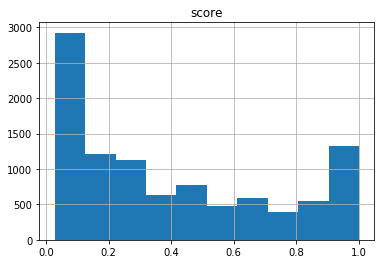

In [ ]:
ds2.hist(column="score")

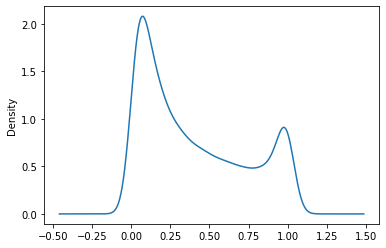

In [ ]:
ds2["score"].plot.density()

**Data Cleaning and Labeling**

In [ ]:
ds2 = ds2[ds2["2019/12/31"]!=0] #removing last month zero values

In [ ]:
labeled_data= pd.DataFrame(columns = ds2.columns)
labeled_data["customer_id"] = ds2["customer_id"]
labeled_data["score"] = ds2["score"]

#condslist = [ds2.iloc[:,column]==0,ds2.iloc[:,column+1]==0 and ds2.iloc[:,column+2]==0]
#choicelist = [0,2]

for column in range(1,len(ds2.columns)-3):
  column_name= ds2.columns[column]
  next_column = ds2.columns[column+1]
  next_column_2 = ds2.columns[column+2]
  labeled_data[column_name] = ds2[column_name]==0

  
#labeled_data[column_name] = np.select([ds2[column_name]==0,ds2[next_column]==0 & ds2[next_column_2]==0],[0,2],1)

In [ ]:
for column in range(1,len(labeled_data.columns)-3):
  column_name= labeled_data.columns[column]
  next_column = labeled_data.columns[column+1]
  next_column_2 = labeled_data.columns[column+2]
  labeled_data[column_name] = np.select([labeled_data[column_name]==True,labeled_data[next_column] & labeled_data[next_column_2]],[0,2],1)

In [ ]:
labeled_data.to_csv("labeled_data.csv")

In [ ]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5183 entries, 0 to 9997
Data columns (total 38 columns):
customer_id    5183 non-null int64
2017/01/31     5183 non-null int64
2017/02/28     5183 non-null int64
2017/03/31     5183 non-null int64
2017/04/30     5183 non-null int64
2017/05/31     5183 non-null int64
2017/06/30     5183 non-null int64
2017/07/31     5183 non-null int64
2017/08/31     5183 non-null int64
2017/09/30     5183 non-null int64
2017/10/31     5183 non-null int64
2017/11/30     5183 non-null int64
2017/12/31     5183 non-null int64
2018/01/31     5183 non-null int64
2018/02/28     5183 non-null int64
2018/03/31     5183 non-null int64
2018/04/30     5183 non-null int64
2018/05/31     5183 non-null int64
2018/06/30     5183 non-null int64
2018/07/31     5183 non-null int64
2018/08/31     5183 non-null int64
2018/09/30     5183 non-null int64
2018/10/31     5183 non-null int64
2018/11/30     5183 non-null int64
2018/12/31     5183 non-null int64
2019/01/31     518

In [ ]:
top_customers = ds2.sort_values("score",ascending=False).head(4000)
top_customers_labels = labeled_data.sort_values("score",ascending=False).head(4000)

top_customers["score"].describe()

count    4000.000000
mean        0.707264
std         0.242732
min         0.277778
25%         0.500000
50%         0.750000
75%         0.944444
max         1.000000
Name: score, dtype: float64

In [ ]:
X = top_customers.iloc[:,1:-3]
y = top_customers_labels.iloc[:,1:-3]

In [ ]:
X.head()

,2017/01/31,2017/02/28,2017/03/31,2017/04/30,2017/05/31,2017/06/30,2017/07/31,2017/08/31,2017/09/30,2017/10/31,2017/11/30,2017/12/31,2018/01/31,2018/02/28,2018/03/31,2018/04/30,2018/05/31,2018/06/30,2018/07/31,2018/08/31,2018/09/30,2018/10/31,2018/11/30,2018/12/31,2019/01/31,2019/02/28,2019/03/31,2019/04/30,2019/05/31,2019/06/30,2019/07/31,2019/08/31,2019/09/30,2019/10/31
0,1814.65,2839.84,2007.77,11140.48,12518.97,22437.70,16388.71,2100.13,10748.24,6243.52,3822.42,19178.65,2143.51,11083.20,16986.45,31158.53,662.50,1052.02,6636.67,5918.20,20457.27,2353.60,13921.54,14523.55,5999.58,22948.09,8733.90,19529.14,5977.45,11808.22,12936.34,11165.31,29615.50,59116.10
1164,25792.68,18356.45,21908.97,26527.82,12171.21,1818.15,11026.69,14918.14,19464.11,46195.51,34745.73,31878.27,38322.49,26452.15,28109.83,18011.98,43070.17,34161.81,21190.30,30135.86,53718.70,24261.42,44495.10,38102.67,28641.58,46066.93,26140.75,33210.73,16866.25,63370.42,46040.50,54291.82,33762.97,37992.64
1166,7699.03,21459.67,20777.59,7353.25,6062.46,8186.93,9734.01,9390.27,15551.08,9874.54,1224.03,38357.64,9965.71,14224.00,11692.30,7346.01,4424.26,14674.96,71338.27,13390.69,6000.54,4973.50,3029.59,7515.79,8342.07,21671.65,5440.15,8133.85,20637.55,7144.00,41715.76,44903.31,9249.37,10502.56
1167,10441.05,4103.74,16461.75,9127.21,13645.82,17651.28,7401.92,17713.00,18322.98,48827.40,39501.79,30113.78,53532.25,12099.19,29265.10,58218.44,43705.27,14566.78,23103.64,36760.24,49850.16,48007.65,59431.69,61676.83,48819.81,27902.71,27753.79,11800.87,31597.06,11671.32,37008.40,35477.08,16551.43,14184.82
1173,14993.32,11093.34,10489.54,5265.89,13123.75,5955.63,20590.41,3641.29,12076.20,9643.69,4845.72,9822.01,11463.97,11112.84,12639.10,4611.17,12721.90,10669.22,18631.21,14633.31,27685.47,1736.56,6290.70,8380.26,7561.05,8587.05,7593.64,16251.93,956.10,13809.63,12928.33,19824.24,7685.72,4120.29


In [ ]:
X = X.to_numpy()
y = y.to_numpy()

X = X[:,:,np.newaxis]
y = y[:,:,np.newaxis]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#Basic Time Series Classification with LSTM RNN
model  = keras.models.Sequential([
                                  keras.layers.LSTM(units=10,return_sequences=True,input_shape=[34,1]),
                                  keras.layers.LSTM(units=10,return_sequences=True),
                                  keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 34, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 34, 10)            840       
_________________________________________________________________
time_distributed (TimeDistri (None, 34, 1)             11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2680 samples, validate on 1320 samples
Epoch 1/50
2680/2680 - 6s - loss: 0.1650 - val_loss: 0.1113
Epoch 2/50
2680/2680 - 4s - loss: 0.1073 - val_loss: 0.0894
Epoch 3/50
2680/2680 - 4s - loss: 0.0846 - val_loss: 0.0669
Epoch 4/50
2680/2680 - 4s - loss: 0.0612 - val_loss: 0.0468
Epoch 5/50
2680/2680 - 4s - loss: 0.0438 - val_loss: 0.0359
Epoch 6/50
2680/2680 - 4s - loss: 0.0362 - val_loss: 0.0326
Epoch 7/50
2680/2680 - 4s - loss: 0.0339 - val_loss: 0.0314
Epoch 8/50
2680/2680 - 4s - loss: 0.0329 - val_loss: 0.0307
Epoch 9/50
2680/2680 - 4s - loss: 0.0322 - val_loss: 0.0302
Epoch 10/50
2680/2680 - 4s - loss: 0.0317 - val_loss: 0.0298
Epoch 11/50
2680/2680 - 4s - loss: 0.0313 - val_loss: 0.0294
Epoch 12/50
2680/2680 - 4s - loss: 0.0310 - val_loss: 0.0291
Epoch 13/50
2680/2680 - 4s - loss: 0.0307 - val_loss: 0.0289
Epoch 14/50
2680/2680 - 4s - loss: 0.0305 - val_loss: 0.0287
Epoch 15/50
2

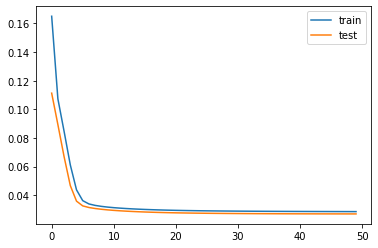

In [ ]:
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.save('lstm_model.h5_1')

In [ ]:
prediction_data = top_customers.iloc[:,3:-1]
prediction_data_np = prediction_data.to_numpy(copy=True)
prediction_data_np = prediction_data_np[:,:,np.newaxis]

In [ ]:
prediction_data.head()

,2017/03/31,2017/04/30,2017/05/31,2017/06/30,2017/07/31,2017/08/31,2017/09/30,2017/10/31,2017/11/30,2017/12/31,2018/01/31,2018/02/28,2018/03/31,2018/04/30,2018/05/31,2018/06/30,2018/07/31,2018/08/31,2018/09/30,2018/10/31,2018/11/30,2018/12/31,2019/01/31,2019/02/28,2019/03/31,2019/04/30,2019/05/31,2019/06/30,2019/07/31,2019/08/31,2019/09/30,2019/10/31,2019/11/30,2019/12/31
0,2007.77,11140.48,12518.97,22437.70,16388.71,2100.13,10748.24,6243.52,3822.42,19178.65,2143.51,11083.20,16986.45,31158.53,662.50,1052.02,6636.67,5918.20,20457.27,2353.60,13921.54,14523.55,5999.58,22948.09,8733.90,19529.14,5977.45,11808.22,12936.34,11165.31,29615.50,59116.10,33955.39,10277.41
1164,21908.97,26527.82,12171.21,1818.15,11026.69,14918.14,19464.11,46195.51,34745.73,31878.27,38322.49,26452.15,28109.83,18011.98,43070.17,34161.81,21190.30,30135.86,53718.70,24261.42,44495.10,38102.67,28641.58,46066.93,26140.75,33210.73,16866.25,63370.42,46040.50,54291.82,33762.97,37992.64,48409.62,48171.49
1166,20777.59,7353.25,6062.46,8186.93,9734.01,9390.27,15551.08,9874.54,1224.03,38357.64,9965.71,14224.00,11692.30,7346.01,4424.26,14674.96,71338.27,13390.69,6000.54,4973.50,3029.59,7515.79,8342.07,21671.65,5440.15,8133.85,20637.55,7144.00,41715.76,44903.31,9249.37,10502.56,13300.42,25190.32
1167,16461.75,9127.21,13645.82,17651.28,7401.92,17713.00,18322.98,48827.40,39501.79,30113.78,53532.25,12099.19,29265.10,58218.44,43705.27,14566.78,23103.64,36760.24,49850.16,48007.65,59431.69,61676.83,48819.81,27902.71,27753.79,11800.87,31597.06,11671.32,37008.40,35477.08,16551.43,14184.82,18983.50,19556.17
1173,10489.54,5265.89,13123.75,5955.63,20590.41,3641.29,12076.20,9643.69,4845.72,9822.01,11463.97,11112.84,12639.10,4611.17,12721.90,10669.22,18631.21,14633.31,27685.47,1736.56,6290.70,8380.26,7561.05,8587.05,7593.64,16251.93,956.10,13809.63,12928.33,19824.24,7685.72,4120.29,14503.81,23291.53


In [ ]:
predictions = model.predict(prediction_data_np)

In [ ]:
predictions_dataframe=  pd.DataFrame(data=np.reshape(predictions,(4000,34)),columns=ds2.columns[3:-1])

In [ ]:
predictions_dataframe.describe()

,2017/03/31,2017/04/30,2017/05/31,2017/06/30,2017/07/31,2017/08/31,2017/09/30,2017/10/31,2017/11/30,2017/12/31,2018/01/31,2018/02/28,2018/03/31,2018/04/30,2018/05/31,2018/06/30,2018/07/31,2018/08/31,2018/09/30,2018/10/31,2018/11/30,2018/12/31,2019/01/31,2019/02/28,2019/03/31,2019/04/30,2019/05/31,2019/06/30,2019/07/31,2019/08/31,2019/09/30,2019/10/31,2019/11/30,2019/12/31
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.550468,0.578969,0.560464,0.564937,0.588399,0.605267,0.621945,0.634329,0.636116,0.681599,0.675940,0.680109,0.717932,0.748059,0.753757,0.749675,0.769706,0.780385,0.792233,0.806140,0.819106,0.862454,0.864021,0.843990,0.876777,0.888680,0.871700,0.870170,0.865710,0.867696,0.854070,0.873759,0.879737,1.049703
std,0.511067,0.538842,0.529511,0.525848,0.525719,0.524833,0.523405,0.521016,0.519392,0.513894,0.512297,0.509703,0.500198,0.487963,0.481044,0.480190,0.470626,0.462673,0.456180,0.446543,0.437639,0.407033,0.400214,0.412202,0.386059,0.374254,0.384968,0.385083,0.388668,0.387956,0.396866,0.382780,0.375865,0.064482
min,0.028134,-0.016249,-0.020611,-0.021173,-0.018929,-0.015052,-0.013895,-0.013225,-0.016027,-0.019929,-0.019807,-0.021420,-0.022917,-0.021586,-0.025523,-0.024951,-0.023985,-0.029301,-0.030001,-0.029706,-0.032393,-0.028496,-0.030995,-0.031292,-0.031540,-0.031747,-0.031918,-0.029099,-0.032178,-0.032275,-0.029520,-0.029410,-0.032003,0.992641
25%,0.028134,-0.002052,-0.008068,-0.002407,0.003583,0.007467,0.009648,0.010522,0.010353,0.009409,0.007959,0.007515,0.011739,0.015025,0.017163,0.015964,0.018767,0.024182,1.008915,1.008533,1.008211,1.007939,1.007712,1.007523,1.007365,1.007234,1.007125,1.007034,1.006959,1.006897,1.006166,1.006804,1.006769,1.006740
50%,1.050578,1.071103,1.023815,1.011761,1.010607,1.012258,1.013962,1.014939,1.015191,1.014915,1.014315,1.013549,1.012729,1.011922,1.011168,1.010487,1.009886,1.010550,1.013481,1.014556,1.015092,1.015556,1.014424,1.012890,1.013228,1.013261,1.012259,1.011862,1.011392,1.011415,1.010810,1.011393,1.011455,1.017995
75%,1.050578,1.071103,1.023815,1.011761,1.010607,1.012258,1.018530,1.028503,1.033879,1.046377,1.044105,1.042947,1.052551,1.061228,1.056407,1.050655,1.049096,1.048154,1.048125,1.047187,1.048304,1.053656,1.048522,1.041469,1.044400,1.042987,1.036980,1.035629,1.034045,1.034182,1.031572,1.034815,1.034875,1.069797
max,1.050578,1.107807,1.203018,1.286823,1.328261,1.347012,1.349231,1.340532,1.331822,1.333562,1.321938,1.319319,1.329093,1.332453,1.316584,1.321017,1.305364,1.306454,1.303053,1.321823,1.302681,1.296341,1.294110,1.300528,1.300383,1.315537,1.304693,1.332316,1.304209,1.301925,1.312505,1.324375,1.298201,1.303856


In [ ]:
predictions = np.reshape(predictions,(4000, 34))


In [ ]:
y_pred = predictions[:,-1]

In [ ]:
min_max_scaler = MinMaxScaler()
predictions_scaled = min_max_scaler.fit_transform(predictions)


In [ ]:
y_pred = predictions_scaled[:,-1]

In [ ]:
y_pred_dataframe = pd.DataFrame(y_pred, columns=["probability"])

In [ ]:
y_pred_dataframe["customer_id"] = top_customers["customer_id"]

In [ ]:
final_probabilities = pd.DataFrame(data={"customer_id" : top_customers["customer_id"].to_numpy(),"probability": y_pred_dataframe["probability"].to_numpy()})
#final_probabilities["customer_id"] = top_customers["customer_id"]
#final_probabilities["probability"] = y_pred_dataframe["probability"]

In [ ]:
final_probabilities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
customer_id    4000 non-null int64
probability    4000 non-null float32
dtypes: float32(1), int64(1)
memory usage: 47.0 KB


In [ ]:
last_csv = final_probabilities.sort_values('probability',ascending=False)

**Submission file with sorted list of regular customers and their churn probabilities**

In [ ]:
last_csv.to_csv("final.csv")